# Pipeline freq-time analyses: 
#### inspired by: https://github.com/hoechenberger/pybrain_mne/
#### adapted by: Beatrice PDK
#### This pipeline uses MNE Python to explore spectral content of the data on the frequency and time-frequency domains working from Epochs: 
####                                https://github.com/hoechenberger/pybrain_mne/blob/main/07-time_frequency.ipynb


In [29]:


import pathlib
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

import mne
import mne_bids
from mne import viz
import numpy as np

mne.set_log_level('warning')



#### Select which file you want to import by specifying ID, session, and task

In [2]:
ID = "001"
session = "01"
task = "pre"

#### Import the Epoch file

In [3]:
path_epochs = "./eeg_output/doc-tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_epoch_eeg.fif".format(ID, session, ID, session, task)
path_epochs


'./eeg_output/doc-tacs/sub-001/ses-01/eeg/sub-001_ses-01_task-pre_epoch_eeg.fif'

#### Set parameters

In [4]:
epochs =  mne.read_epochs(path_epochs)


/tmp/ipykernel_16456/255478258.py:1: RuntimeWarning: This filename (./eeg_output/doc-tacs/sub-001/ses-01/eeg/sub-001_ses-01_task-pre_epoch_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs =  mne.read_epochs(path_epochs)


In [5]:
epochs


Number of events,16
Events,1: 16
Time range,0.000 – 9.996 sec
Baseline,off


#### Frequency analysis 

We start by exploring the frequence content of our epochs.

Let's first check out all channel types by averaging across epochs.



REMARK:

    Select a frequency range in the plot to inspect topographies
    The "bandwidth" parameter controls the spectral resolution of the multitaper. You can increase the resolution by chosing a narrower bandwidth at the cost of longer computation time.



In [42]:
%matplotlib qt
epochs.plot_psd(fmax=55, bandwidth= 2)
plt.savefig('./out_figures/doc-tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_epochs.png'.format(ID,session,task,ID,session,task))

In order to choose specific channels

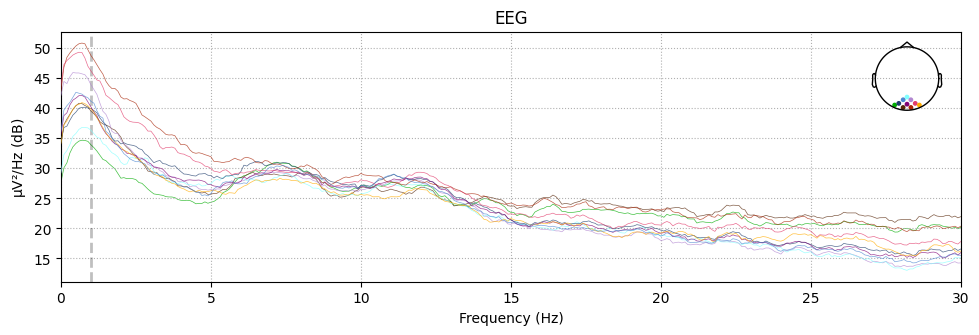

In [19]:
%matplotlib qt
epochs.plot_psd( fmax = 30, picks= ['E72','E75', 'E70','E71','E76','E83','E69','E89','E82','E74'])#select specific electrodes

Now let's take a look at the spatial distributions of the PSD.

In [43]:
epochs.plot_psd_topomap(ch_type='eeg', normalize=False)
plt.savefig('./out_figures/doc-tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_topo_epochs.png'.format(ID,session,task,ID,session,task))


It can be interesting to consider the relative power, defined as the power in a given band divided by the total power. To explore this option, have a look at the "normalize" keyword.



In [44]:
epochs.plot_psd_topomap(ch_type='eeg', normalize=True)
plt.savefig('./out_figures/doc-tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_topo_relativepower.png'.format(ID,session,task,ID,session,task))

Time-frequency analysis: power and inter-trial coherence

We now compute time-frequency representations (TFRs) from our Epochs. We'll look at power and inter-trial coherence (ITC).

To this we'll use the function mne.time_frequency.tfr_morlet but you can also use mne.time_frequency.tfr_multitaper or mne.time_frequency.tfr_stockwell.

In [32]:
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([2, 30]), num=20)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                                           return_itc=True, decim=3, n_jobs=1)


In [33]:
power.crop(-0.1, 0.7)  # crop to remove edge artifacts

<AverageTFR | time : [0.000000, 0.696000], freq : [2.000000, 30.000000], nave : 16, channels : 105, ~1.1 MB>

In [34]:

itc.crop(-0.1, 0.7)  # crop to remove edge artifacts

<AverageTFR | time : [0.000000, 0.696000], freq : [2.000000, 30.000000], nave : 16, channels : 105, ~1.1 MB>

Inspect power

The generated figures are interactive. In the topo you can click on an image to visualize the data for one sensor. You can also select a portion in the time-frequency plane to obtain a topomap for a certain time-frequency region.

In [35]:
baseline_mode = 'logratio'
baseline = (None, 0)


Plot power topomap

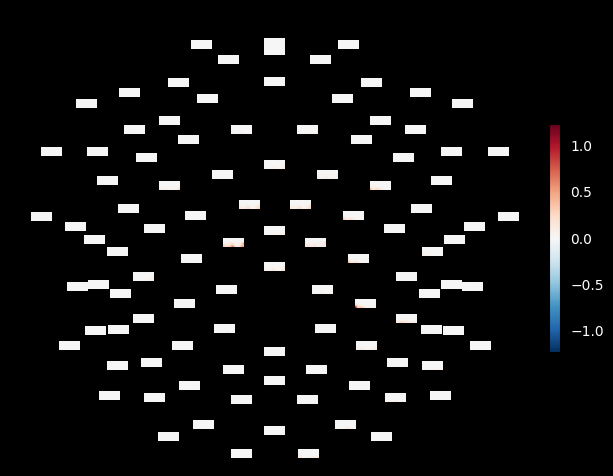

In [38]:
(power.copy()
 .pick_types(eeg=True, meg=False)
 .plot_topo())


Plot power of an individual channel

In [39]:
power.plot(picks='E75', baseline=baseline, mode=baseline_mode)

[<Figure size 640x480 with 2 Axes>]

Plot topomaps for specified frequency ranges

In [46]:
fig, axis = plt.subplots(1, 3, figsize=(7, 4))
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=4, fmax=7,
                   baseline=baseline, mode=baseline_mode, axes=axis[0],
                   title='Theta', show=False, contours=1)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=baseline, mode=baseline_mode, axes=axis[1],
                   title='Alpha', show=False, contours=1)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=15, fmax=30,
                   baseline=baseline, mode=baseline_mode, axes=axis[2],
                   title='Beta', show=False, contours=1)
mne.viz.tight_layout()
plt.show()

plt.savefig('./out_figures/doc-tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_topo_specific_freq.png'.format(ID,session,task,ID,session,task))


Joint Plot

You can also create a joint plot showing both the aggregated TFR across channels and topomaps at specific times and frequencies to obtain a quick overview regarding oscillatory effects across time and space.


In [53]:
power.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.05, 20), (0.1, 11.)])
plt.show()

Inspect ITC



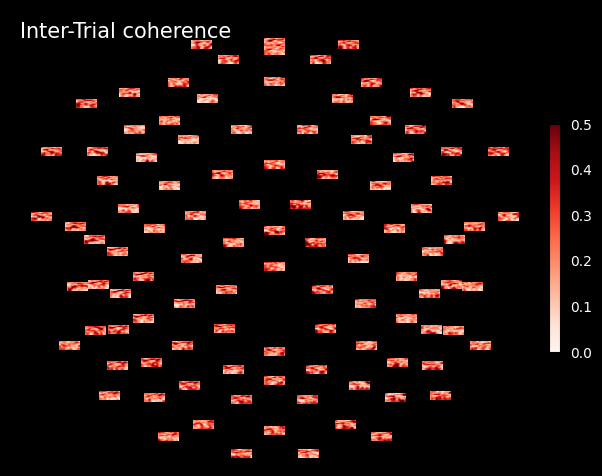

In [55]:
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=0.5, cmap='Reds')

Baseline correction can be applied to power or done in plots. To illustrate the baseline correction in plots, the next line is commented power.apply_baseline(baseline=(-0.5, 0), mode='logratio')

In [56]:
power.apply_baseline(baseline=(-0.5, 0), mode='logratio')

<AverageTFR | time : [0.000000, 0.696000], freq : [2.000000, 30.000000], nave : 16, channels : 105, ~1.1 MB>

In [61]:
power.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.05, 2.), (0.1, 15)])
plt.show()

In [62]:
itc.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.05, 2.), (0.1, 11.)])
plt.show()
